# 0. Imports

In [1]:
import os
import csv

import numpy as np
import pandas as pd
from datetime import date


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances
#from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, Product
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C 

from gmr.utils import check_random_state
from gmr import MVN, GMM, plot_error_ellipses

# 1. Loading and preprocessing dataset

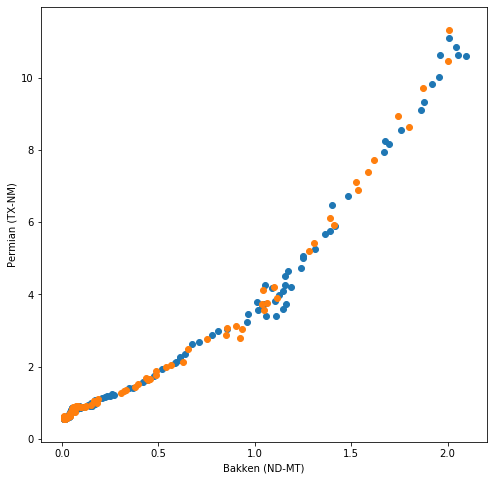

In [65]:
#renommer les colonnes portant le même nom que d'autres
def mangle_dupe_cols(columns):
    counts = {}
    for i, col in enumerate(columns):
        cur_count = counts.get(col, 0)
        if cur_count > 0:
            columns[i] = '%s.%d' % (col, cur_count)
        counts[col] = cur_count + 1
    return columns


def load_data():
    datapath = os.path.join('../dataset', fileName+'_data.csv')
    headerpath = os.path.join('../dataset', fileName+'_header.csv')
    
    data = list(csv.reader(open(datapath), delimiter=csvDelimiter)) 
    datanp = np.asarray(data).astype(np.float)
 
    header = list(csv.reader(open(headerpath), delimiter=csvDelimiter))
    header = header[0]
    datapd = pd.DataFrame(data, columns=mangle_dupe_cols(header))
    return datanp, datapd, header

#Choosing file to load :
fileName = 'shalegas' #shalegas, MLO2, noisysine
csvDelimiter = ','

datanp, datapd, headers = load_data()
data = datapd

#Splitting train/test :
ratioTrainTest = 0.6

x_train,x_test=train_test_split(data,train_size=ratioTrainTest,\
                                test_size=(1-ratioTrainTest),\
                                random_state=int(np.random.rand()*0))

if fileName == 'MLO2' or fileName == 'MLO':
    x_col = ['decimalDate']
    y_col = ['interpolated']
elif fileName == 'noisySine':
    x_col = ['x']
    y_col  = ['y']
elif fileName == 'shalegas':
    #x_col = ['Permian (TX-NM)','Marcellus (PA-WV-OH-NY)']
    #x_col = ['Marcellus (PA-WV-OH-NY)']
    #x_col = ['Bakken (ND-MT)','Marcellus (PA-WV-OH-NY)']
    x_col = ['Bakken (ND-MT)']
    #y_col = ['Utica (OH-PA-WV)']
    y_col  = ['Permian (TX-NM)']

x_tr = x_train.loc[:,x_col].astype(float)
y_tr = x_train.loc[:,y_col].astype(float)
x_te = x_test.loc[:,x_col].astype(float)
y_te = x_test.loc[:,y_col].astype(float)

#Displaying the chosen dimensions :
if (np.size(x_col) == 1) :
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.scatter(x_tr[x_col[0]], y_tr, label='train')
    ax.scatter(x_te[x_col[0]], y_te, label='test')
    ax.set_xlabel(x_col[0])
    ax.set_ylabel(y_col[0])
    plt.show()



if (np.size(x_col) == 2) :
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x_tr[x_col[0]], x_tr[x_col[1]], y_tr, label='train')
    ax.scatter(x_te[x_col[0]], x_te[x_col[1]], y_te, label='test')

    ax.set_xlabel(x_col[0])
    ax.set_ylabel(x_col[1])
    ax.set_zlabel(y_col[0])

    plt.show()

# 2. GPR

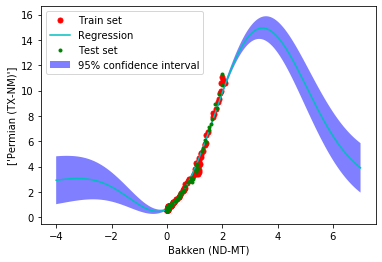

In [66]:
#Hyperparameters :
kernel_w = 2
gpr_kernel = RBF(float(kernel_w))

#Model :
gp = GaussianProcessRegressor(kernel=gpr_kernel, alpha=0.1, optimizer=None, n_restarts_optimizer=0, \
                              normalize_y=True)

# Mesh the input space for evaluations of the real function, the prediction and its MSE
X = np.atleast_2d(x_tr)
y = np.atleast_2d(y_tr).T.ravel()

for i in range(X.shape[1]):
    if i == 0:
        x_grid = np.atleast_2d(np.linspace(int(np.min(X[:,i])-5), int(np.max(X[:,i])+5), 1000)).T
    else:
        x_grid = np.hstack((x_grid, np.transpose(np.atleast_2d(np.linspace(int(np.min(X[:,i])-5), \
                                                                           int(np.max(X[:,i])+5), 1000)))))

gp.fit(X, y)

#Predictions :
y_pred, std = gp.predict(x_grid, return_std=True)


if (np.size(x_col) == 1) :
    plt.figure()
    plt.plot(X, y, 'r.', markersize=10, label='Observations')
    plt.plot(x_grid, y_pred, 'b-', label='Prediction')
    plt.plot(x_te, y_te, 'g.', label="Test set")
    plt.fill(np.concatenate([x_grid, x_grid[::-1]]),
             np.concatenate([y_pred - 1.9600 * std,
                            (y_pred + 1.9600 * std)[::-1]]),
             alpha=.5, fc='b', ec='None', label='95% confidence interval')
    plt.xlabel('%s' % lx)
    plt.ylabel('%s' % y_col)
    plt.legend(loc='upper left')
        
if (np.size(x_col) == 2) :
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_tr[x_col[0]], x_tr[x_col[1]], y_tr, label='train')
    ax.scatter(x_te[x_col[0]], x_te[x_col[1]], y_te, label='test')
    ax.set_xlabel(x_col[0])
    ax.set_ylabel(x_col[1])
    ax.set_zlabel(y_col[0])

    plt.show()